# Building and training CYCLEGAN over photo-monet dataset using TPUs

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
import tensorflow_addons as tfa
import os
import time
from IPython.display import clear_output
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2.2.0


In [4]:
def initialize_tpu(list_tpus=True):
    tpu_address = None
    if 'COLAB_TPU_ADDR' in os.environ:
        tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR'] # if on colab
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
    tf.config.experimental_connect_to_cluster(tpu_resolver) # connecting to the tpu cluster
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver) # intializes the tpu cluster
    if list_tpus:
        print("Associated TPUs :")
        for tpu in tf.config.list_logical_devices('TPU'):
            print('\t',tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
    return strategy

In [5]:
strategy = initialize_tpu()

Associated TPUs :
	 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU')
	 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU')
	 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU')
	 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')
	 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')
	 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU')
	 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')
	 LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')


In [6]:
WIDTH, HEIGHT = 256, 256
EPOCHS = 20
BUFFER_SIZE = 400
BATCH_SIZE = 1
OUTPUT_CHANNEL = 3

LAMBDA = 10

# Loading the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [7]:
DATA_PATH = KaggleDatasets().get_gcs_path()

In [8]:
X_FILENAMES = tf.io.gfile.glob(str(DATA_PATH + '/photo_tfrec/*.tfrec'))
Y_FILENAMES = tf.io.gfile.glob(str(DATA_PATH + '/monet_tfrec/*.tfrec'))

In [15]:
def preprocess(example):
    data_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, data_format)
    img = tf.image.decode_jpeg(example['image'])
    img = tf.cast(img, tf.float32)
    img = tf.reshape(img, [HEIGHT, WIDTH, 3])
    img = img/127.5 - 1 # normalising
    return img

def get_dataset(filenames):
    ds = tf.data.TFRecordDataset(filenames).map(preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return ds

In [16]:
train_x, train_y = get_dataset(X_FILENAMES), get_dataset(Y_FILENAMES)

In [17]:
sample_x = next(iter(train_x))
sample_y = next(iter(train_y))

Get a look at the data

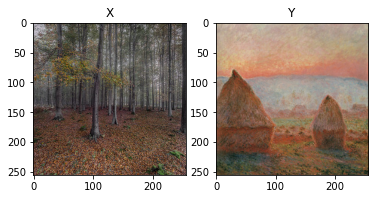

In [18]:
plt.subplot(121)
plt.title('X')
plt.imshow(sample_x[0] * 0.5 + 0.5)
plt.subplot(122)
plt.title('Y')
plt.imshow(sample_y[0] * 0.5 + 0.5)

## Basic key layers for Generator and discriminator

In [19]:
def add_layer(filters, kernel_size,instantnorm = True):
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.random_normal_initializer(0., 0.02)
    blocks = Sequential()
    blocks.add(layers.Conv2D(filters, kernel_size=kernel_size, strides = 2, kernel_initializer=init,padding='same', use_bias=False))
    if instantnorm:
        blocks.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    blocks.add(layers.LeakyReLU())
    return blocks

def add_trans_layer(filters, kernel_size, dropout=True):
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.random_normal_initializer(0., 0.02)
    blocks = Sequential()
    blocks.add(layers.Conv2DTranspose(filters, kernel_size, strides=2, kernel_initializer=init, use_bias=False, padding='same'))
    blocks.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if dropout:
        blocks.add(layers.Dropout(0.5))
    blocks.add(layers.LeakyReLU())
    return blocks


# Build the generator


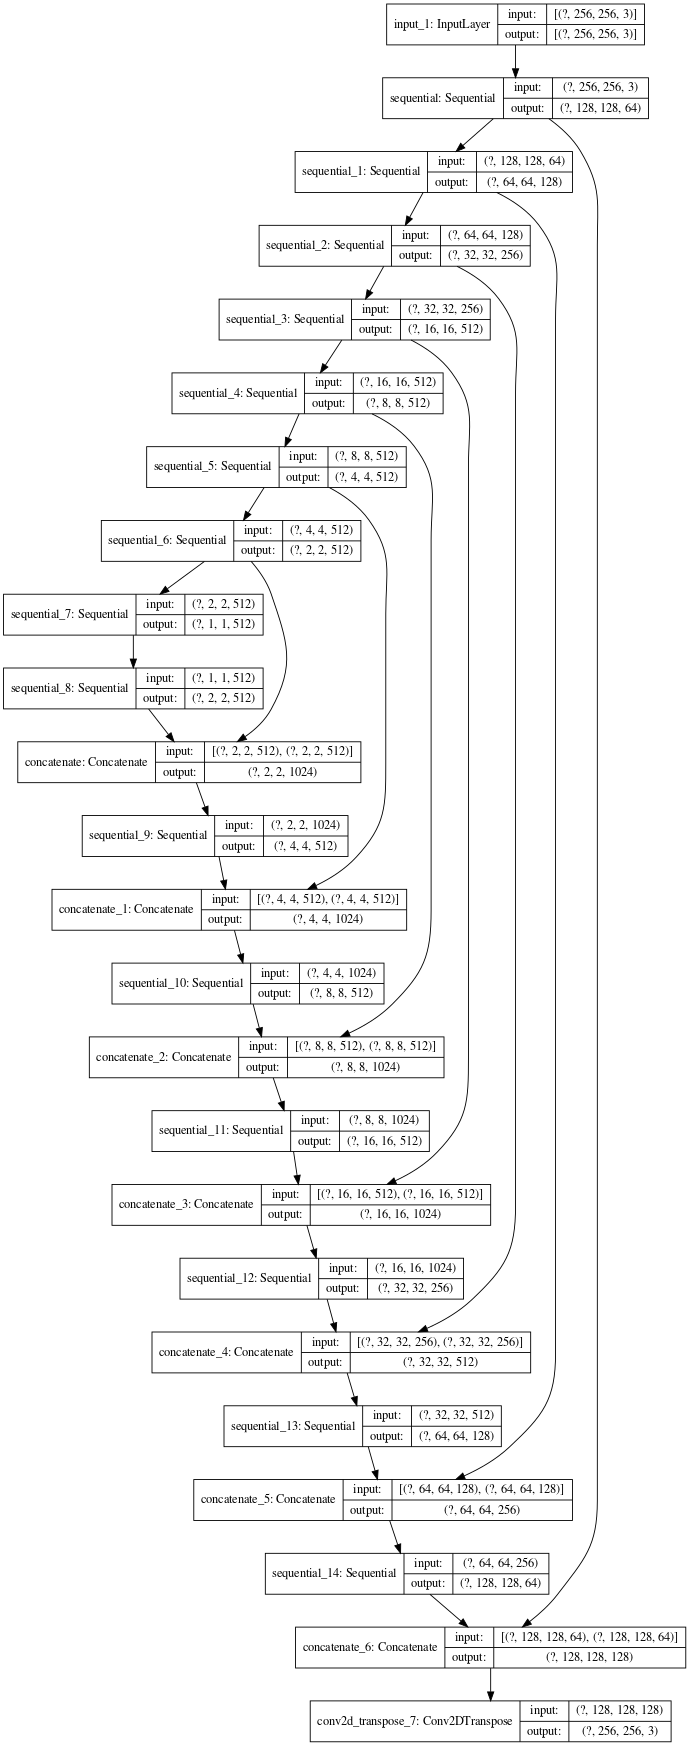

In [20]:
def make_gen():
    inputs = layers.Input(shape = [256, 256, 3])

    down = [
        add_layer(64, 5, False),
        add_layer(128, 5),
        add_layer(256, 5),
        add_layer(512, 5),
        add_layer(512, 5),
        add_layer(512, 5),
        add_layer(512, 5),
        add_layer(512, 5)
    ]

    up = [
          add_trans_layer(512, 5),
          add_trans_layer(512, 5),
          add_trans_layer(512, 5),
          add_trans_layer(512, 5, dropout=False),
          add_trans_layer(256, 5, dropout=False),
          add_trans_layer(128, 5, dropout=False),
          add_trans_layer(64, 5, dropout=False)
    ]

    init = tf.random_normal_initializer(0., 0.02)

    output = layers.Conv2DTranspose(OUTPUT_CHANNEL, kernel_size=5, strides=(2,2), padding='same', kernel_initializer=init, activation='tanh')

    x = inputs

    stack = []

    for d in down:
        x = d(x)
        stack.append(x)
  
    stack.pop(-1)

    for a in up:
        x = a(x)
        x = layers.Concatenate()([x, stack[-1]])
        stack.pop(-1)

    x = output(x)
  
    return Model(inputs = inputs, outputs=x)


tf.keras.utils.plot_model(make_gen(), show_shapes=True, dpi=64)

# Build the discriminator

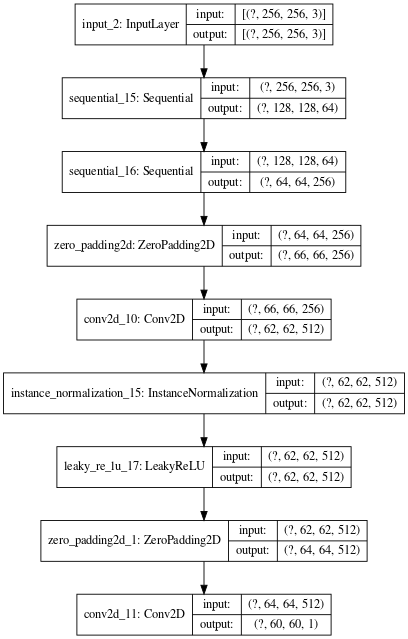

In [21]:
def make_disc():
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    input_shape = [256, 256, 3]

    down = [
            add_layer(64, (5,5), instantnorm=False),
            add_layer(256, (5,5)),
            layers.ZeroPadding2D(),
            layers.Conv2D(512, kernel_size=(5,5), kernel_initializer=init, use_bias=False),
            tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
            layers.LeakyReLU(),
            layers.ZeroPadding2D(),
            layers.Conv2D(1, kernel_size=(5,5), kernel_initializer=init)
    ]

    inp = layers.Input(shape=input_shape)

    x = inp
    for layer in down:
        x = layer(x)
  
    return Model(inputs=inp, outputs = x)


tf.keras.utils.plot_model(make_disc(), show_shapes=True, dpi=64)

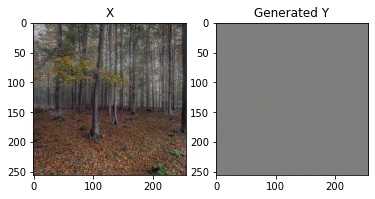

<Figure size 432x288 with 0 Axes>

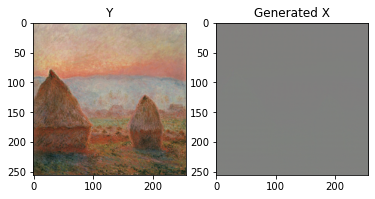

In [22]:
plt.figure()
plt.subplot(121)
plt.title("X")
plt.imshow(sample_x[0] * 0.5 + 0.5)
plt.subplot(122)
plt.title("Generated Y")
plt.imshow(make_gen()(sample_x)[0] * 0.5 + 0.5)
plt.figure()

plt.figure()
plt.subplot(121)
plt.title("Y")
plt.imshow(sample_y[0] * 0.5 + 0.5)
plt.subplot(122)
plt.title("Generated X")
plt.imshow(make_gen()(sample_y)[0] * 0.5 + 0.5)


# Define loss functions

Discriminator loss is same as DCGAN loss. It classifies whether the input is correct or not.
Generator loss is different than than the DCGAN and pix2pix here it also includes the identity loss and cyclic loss. Cyclic loss is calculated by passing the inputs through generator 1 and its output is fed to Generator 2 and l1 loss of both the images is calculated which then to be minimised by the model. Identity loss is calculated by passing the inputs of Generator 1 in Generator 2 and trying to generate the same image then l1 loss of resulting image is calculated with input image.

In [23]:

with strategy.scope():
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)    
    def gen_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    def disc_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        return fake_loss + real_loss

    def cyclic_loss(real_img, cycled_img):
        return LAMBDA*tf.reduce_mean(abs(real_img-cycled_img))

    def identity_loss(real_img, same_img):
        return 0.5*LAMBDA*tf.reduce_mean(abs(real_img-same_img))

## Make the CycleGAN model by inheriting from tf.keras.Model

In [24]:
class CycleGAN(Model):
    
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.Gx = make_gen() # converts X -> Y => fake_y = Gx(input_x)
        self.Gy = make_gen() # converts Y -> X
        self.Dx = make_disc() # checks wheather the input is X or not
        self.Dy = make_disc() # checks wheather the input is Y or not
    
    def compile(self, gen_loss, disc_loss, cyclic_loss, identity_loss):
        super(CycleGAN, self).compile()
        self.Gx_opt = tf.keras.optimizers.Adam(1e-4)
        self.Gy_opt = tf.keras.optimizers.Adam(1e-4)
        self.Dx_opt = tf.keras.optimizers.Adam(1e-4)
        self.Dy_opt = tf.keras.optimizers.Adam(1e-4)
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        self.cyclic_loss = cyclic_loss
        self.identity_loss = identity_loss
    
    def get_plots(self):
        return  {
            "Generators" : tf.keras.utils.plot_model(self.Gx, show_shapes=True, dpi=64),
            "Discriminators" : tf.keras.utils.plot_model(self.Dx, show_shapes=True, dpi=64)
        }
    
    def train_step(self, batch):
        real_x, real_y = batch
        
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.Gx(real_x, training=True)
            fake_x = self.Gy(real_y, training=True)
            cycled_x = self.Gy(fake_y, training=True)
            cycled_y = self.Gx(fake_x, training=True)
            same_x = self.Gy(real_x, training=True)
            same_y = self.Gx(real_y, training=True)
            
            Dx_real = self.Dx(real_x, training=True)
            Dx_fake = self.Dx(fake_x, training=True)
            
            Dy_real = self.Dy(real_y, training=True)
            Dy_fake = self.Dy(fake_y, training=True)
            
            cycled_loss = self.cyclic_loss(real_x, cycled_x) + self.cyclic_loss(real_y, cycled_y)
            
            Gx_loss = self.gen_loss(Dy_fake) + cycled_loss + self.identity_loss(real_x, same_x)
            Gy_loss = self.gen_loss(Dx_fake) + cycled_loss + self.identity_loss(real_y, same_y)
            
            Dx_loss = self.disc_loss(Dx_real, Dx_fake)
            Dy_loss = self.disc_loss(Dy_real, Dy_fake)
        
        Gx_grad = tape.gradient(Gx_loss, self.Gx.trainable_variables)
        Gy_grad = tape.gradient(Gy_loss, self.Gy.trainable_variables)
        Dx_grad = tape.gradient(Dx_loss, self.Dx.trainable_variables)
        Dy_grad = tape.gradient(Dy_loss, self.Dy.trainable_variables)
        
        self.Gx_opt.apply_gradients(zip(Gx_grad, self.Gx.trainable_variables))
        self.Gy_opt.apply_gradients(zip(Gy_grad, self.Gy.trainable_variables))
        self.Dx_opt.apply_gradients(zip(Dx_grad, self.Dx.trainable_variables))
        self.Dy_opt.apply_gradients(zip(Dy_grad, self.Dy.trainable_variables))
        
        return {
            "Gx_loss" : Gx_loss,
            "Gy_loss" : Gy_loss,
            "Dx_loss" : Dx_loss,
            "Dy_loss" : Dy_loss,
            "cycled_loss" : cycled_loss
        }
    


## Compile and train the model

### Compilation and declaration must be inside the scope for tpu usage

In [25]:
with strategy.scope():
    cyclegan = CycleGAN()
    cyclegan.compile(gen_loss=gen_loss, disc_loss=disc_loss, cyclic_loss=cyclic_loss, identity_loss=identity_loss)

In [26]:
history = cyclegan.fit(tf.data.Dataset.zip((train_x, train_y)), epochs=EPOCHS)

Epoch 1/20
300/300 [==============================] - 53s 177ms/step - Dy_loss: 1.1902 - cycled_loss: 4.4038 - Gy_loss: 6.1203 - Gx_loss: 6.3068 - Dx_loss: 1.2310
Epoch 2/20
300/300 [==============================] - 54s 179ms/step - Dy_loss: 1.1916 - cycled_loss: 2.7990 - Gy_loss: 4.2348 - Gx_loss: 4.3688 - Dx_loss: 1.2683
Epoch 3/20
300/300 [==============================] - 54s 179ms/step - Dy_loss: 0.8363 - cycled_loss: 2.6240 - Gy_loss: 4.3797 - Gx_loss: 4.6025 - Dx_loss: 0.9643
Epoch 4/20
300/300 [==============================] - 54s 178ms/step - Dy_loss: 1.1195 - cycled_loss: 2.7017 - Gy_loss: 4.6947 - Gx_loss: 4.7150 - Dx_loss: 0.9257
Epoch 5/20
300/300 [==============================] - 54s 178ms/step - Dy_loss: 1.1265 - cycled_loss: 2.6925 - Gy_loss: 4.7722 - Gx_loss: 4.7224 - Dx_loss: 0.9229
Epoch 6/20
300/300 [==============================] - 54s 179ms/step - Dy_loss: 1.2947 - cycled_loss: 2.6908 - Gy_loss: 4.8346 - Gx_loss: 4.6192 - Dx_loss: 0.9254
Epoch 7/20
300/300 [==

## Test the model trained above
The output is not the best but more tunning with layers and increasing epochs can change the scenario as per one's satisfaction.

In [35]:
def generate_ys(inputs):
    imgs = cyclegan.Gx(inputs)
    
    for i in range(imgs.shape[0]):
        plt.figure()
        plt.subplot(121)
        plt.title("input X")
        plt.imshow(inputs[i,:,:,0]*127.5 + 127.5)
        plt.subplot(122)
        plt.title("generated Y")
        plt.imshow(imgs[i,:,:,0]*127.5 + 127.5)


def generate_xs(inputs):
    imgs = cyclegan.Gy(inputs)

    for i in range(imgs.shape[0]):
        plt.figure()
        plt.subplot(121)
        plt.title("input Y")
        plt.imshow(inputs[i,:,:,0]*127.5 + 127.5)
        plt.subplot(122)
        plt.title("generated X")
        plt.imshow(imgs[i,:,:,0]*127.5 + 127.5)

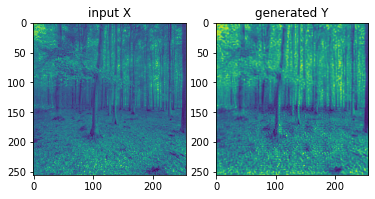

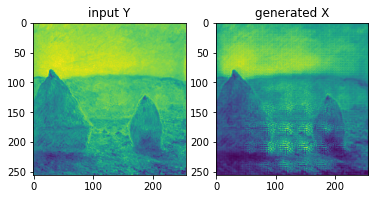

In [36]:
generate_ys(sample_x)
generate_xs(sample_y)